In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools

In [2]:
nr_exc_neurons = 300;
nr_inh_neurons = 80;
nr_neurons = nr_exc_neurons + nr_inh_neurons;
K = 60;

# create an instance of the class HopfieldNetwork with 300 neurons
hopfield_net = network.HopfieldNetwork(nr_neurons = nr_neurons)
#create 5 patterns
factory = pattern_tools.PatternFactory(nr_exc_neurons,1)

#Random seed:
np.random.seed(2705)

In [3]:
import random
def generate_patterns(nr_patterns = 5, activity = 0.):
    pattern_list = factory.create_random_pattern_list(nr_patterns=nr_patterns, on_probability=activity)
    return pattern_list

def to_σ(S):
    SS = np.copy(S)
    for pattern in SS:
        for p in pattern:
            p[0] = (p[0]+1)/2
    return SS;

def weight_matrix(pattern_list,a,nr_exc_neurons, nr_inh_neurons, K):

    N_tot = nr_exc_neurons + nr_inh_neurons;
    W = np.zeros((N_tot,N_tot))
    
    #exc - exc
    for i in range(nr_exc_neurons):
        for j in range(nr_exc_neurons):
            for μ in range(len(pattern_list)):
                W[i][j] = W[i][j] + (pattern_list[μ][i][0])*(pattern_list[μ][j][0]);
            W[i][j] = W[i][j]/nr_exc_neurons
        W[i][i] = 0;
    
    #exc - inh:  
    sum_patterns = []
    for i in range(nr_exc_neurons): 
        s = 0
        for μ in range(len(pattern_list)):
            s += pattern_list[μ][i][0];
        sum_patterns.append(s);
    
    for i in range(nr_exc_neurons): 
        for k in range(nr_exc_neurons,N_tot):
            W[i][k] = -a / nr_inh_neurons * sum_patterns[i]
        
    #inh - exc:
    exc_range = range(nr_exc_neurons)
    for k in range(nr_exc_neurons,N_tot):
        W[k][random.sample(exc_range, K)] = 1/K;       
    
    
    return W

def hamming_distance(P1,P2):
    N = len(P1)
    h = 0
    for i in range(N):
        h = h + 2*(P1[i][0]+ P2[i][0]) - 4 * P1[i][0]*P2[i][0]
    return h/(2*N)
    
def update(nr_exc_neurons,nr_inh_neurons):
    def upd(state_t0,weights):                     
        h_t1 = weights@state_t0
        state_t1 = np.zeros(h_t1.shape)
        #Update excitatory neurons with θ = 0
        
        sgn_aux = np.sign(h_t1[0:nr_exc_neurons]);
        #sign(0) = 0 by default, so we have to convert it to 1
        sgn_aux = [-1. if val == 0. else val for val in sgn_aux]
        
        state_t1[0:nr_exc_neurons] = (np.array(sgn_aux) + np.ones(nr_exc_neurons))/2
        
        #Stochastic update of inhibitory neurons
        for k in range(nr_exc_neurons,nr_inh_neurons + nr_exc_neurons):
            r = np.random.rand()
            #print(r,h_t1[k][0])
            if r < h_t1[k]:
                state_t1[k] = 1
            #print(state_t1[k][0])
            
        return state_t1
    return upd
def update_async(nr_exc_neurons,nr_inh_neurons):
    def upd(state_t0,weights): 
        random_neuron_idx_list = np.random.permutation(len(state_t0))
        state_t1 = state_t0.copy()
        
        for idx in random_neuron_idx_list:
            #Check whether neuron idx in exc or inh:            
            # Neuron idx is excitatory
            if idx < nr_exc_neurons:
                h_i = np.dot(weights[idx, :],state_t1)
                s_i = np.sign(h_i)
                if s_i == 0:
                    s_i = -1
                state_t1[idx] = (s_i+1)/2
            
            #Neuron idx is inhibitory
            else:
                h_k = np.dot(weights[idx, :], state_t1)
                r = np.random.rand()
                #print(r,h_t1[k][0])
                if r < h_k:
                    state_t1[idx] = 1
                else:
                    state_t1[idx] = 0
            
        return state_t1
    return upd

In [4]:
a = 0.1

pattern_list = generate_patterns(nr_patterns = 50,activity = a)
σ_pattern_list = to_σ(pattern_list)
hopfield_net.weights = weight_matrix(σ_pattern_list,a,nr_exc_neurons,nr_inh_neurons,K)
np.set_printoptions(precision=3)
print(hopfield_net.weights)

[[ 0.     0.003  0.003 ... -0.009 -0.009 -0.009]
 [ 0.003  0.     0.003 ... -0.004 -0.004 -0.004]
 [ 0.003  0.003  0.    ... -0.006 -0.006 -0.006]
 ...
 [ 0.     0.     0.    ...  0.     0.     0.   ]
 [ 0.     0.     0.    ...  0.     0.     0.   ]
 [ 0.     0.     0.    ...  0.     0.     0.   ]]


In [5]:
upd = update(nr_exc_neurons,nr_inh_neurons)
upd_async = update_async(nr_exc_neurons,nr_inh_neurons)
σ_0 = to_σ([pattern_tools.flip_n(pattern_list[0], nr_of_flips=int(0.05*nr_exc_neurons))])
        
state = np.concatenate((np.squeeze(σ_0),np.random.choice([1,1],size = nr_inh_neurons)),axis = None)
print(state)
state_1 = upd(np.squeeze(state),hopfield_net.weights)
print(state_1)

[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.

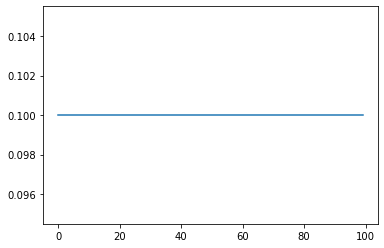

In [6]:
v = []
for i in range(100):
    state_1 = upd(state_1,hopfield_net.weights)
    v.append(hamming_distance(state_1.reshape((nr_neurons,1))[0:nr_exc_neurons],σ_pattern_list[0]))
    
plt.plot(v)
plt.show()

In [7]:
h_t1 = hopfield_net.weights@state_1
print(h_t1)

state_t1 = np.zeros(h_t1.shape)
#Update excitatory neurons with θ = 0

sgn_aux = np.sign(h_t1[0:nr_exc_neurons]);
#sign(0) = 0 by default, so we have to convert it to 1
sgn_aux = [np.random.choice([-1,1]) if val == 0. else val for val in sgn_aux]

print(sgn_aux)

state_t1[0:nr_exc_neurons] = (np.array(sgn_aux) + np.ones(nr_exc_neurons))/2

#Stochastic update of inhibitory neurons
for k in range(nr_exc_neurons,nr_inh_neurons + nr_exc_neurons):
    r = np.random.rand()
    #print(r,h_t1[k][0])
    if r < h_t1[k]:
        state_t1[k] = 1
    #print(state_t1[k][0])

print(state_t1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [8]:
def Mean_Error_Pattern_Retrieval(nr_patterns = 5,
                                 a= 0.5,
                                 nr_exc_neurons = 300,
                                 nr_inh_neurons = 80, 
                                 K= 60,
                                 max_iter = 1000, 
                                 verbose = False,
                                 upd_async = False,
                                 flip_percentage = 0.05,
                                 run_conv = True,
                                 N_runs = 100):
    
    pattern_list = generate_patterns(nr_patterns = nr_patterns,activity = a)
    σ_pattern_list = to_σ(pattern_list)
    hopfield_net.weights = weight_matrix(σ_pattern_list,a,nr_exc_neurons,nr_inh_neurons,K)
    
    if upd_async:
        hopfield_net.set_dynamics_to_user_function(update_async(nr_exc_neurons,nr_inh_neurons))
    else:
        hopfield_net.set_dynamics_to_user_function(update(nr_exc_neurons,nr_inh_neurons))
    
    E = 0;
    accepted_pattern_number = 0
    retrieved_pattern_number = 0
    for μ in range(nr_patterns):    
        noisy_init_state = pattern_tools.flip_n(pattern_list[μ], nr_of_flips=int(flip_percentage*nr_exc_neurons))
        hopfield_net.set_state_from_pattern(to_σ([noisy_init_state]))
        
        #Initialize inhibitory Neurons
        hopfield_net.state = np.concatenate((hopfield_net.state,np.zeros(nr_inh_neurons)),axis = None)
        np.reshape(hopfield_net.state,(nr_exc_neurons+nr_inh_neurons,1))
        
        h = 0;
        if run_conv:
            #Run until convergence
            count = 0;
            conv = False
            while not conv:
                count = count + 1;
                #print(count)
                state_old = hopfield_net.state.copy();
                hopfield_net.run(nr_steps=1);
                state = hopfield_net.state.copy();
                aux = max(abs(state - state_old))
                conv = (aux<1)
                #print(state == state_old)
                #print(conv)
                if count == max_iter:
                    if verbose:
                        print("Network state did not converge for pattern ",μ)
                    break
            if conv:
                if verbose:
                    print('Pattern %i - Converged after %i iterations'%(μ,count)) 
                accepted_pattern_number = accepted_pattern_number + 1;

            state = factory.reshape_patterns([hopfield_net.state[0:nr_exc_neurons]])
            h = hamming_distance(state[0],σ_pattern_list[μ])
            
        else:
           #Run N_runs             
            for run in range(N_runs):
                hopfield_net.run(nr_steps=1);
                state = factory.reshape_patterns([hopfield_net.state[0:nr_exc_neurons]])
                h += hamming_distance(state[0],σ_pattern_list[μ])/N_runs;
            accepted_pattern_number = accepted_pattern_number + 1;
                
        if h<0.1:
            retrieved_pattern_number += 1;
        if verbose:
            print("Hamming distance = ",h)
        E = E + h
                
        
    
    print("Convergence  = %d / %d; Retrieved patterns = %d"%(accepted_pattern_number,nr_patterns,retrieved_pattern_number))

    return E/nr_patterns , retrieved_pattern_number/nr_patterns;

In [9]:
Mean_Error_Pattern_Retrieval(nr_patterns = 50,
                             a= 0.1,
                             nr_exc_neurons = nr_exc_neurons,
                             nr_inh_neurons = nr_inh_neurons, 
                             K= K,
                             upd_async = True,
                             run_conv=False,
                             verbose = True)

Hamming distance =  0.16400000000000012
Hamming distance =  0.12643333333333345
Hamming distance =  0.12979999999999994
Hamming distance =  0.1135333333333335
Hamming distance =  0.12226666666666632
Hamming distance =  0.13513333333333372
Hamming distance =  0.10713333333333319
Hamming distance =  0.10979999999999977
Hamming distance =  0.12139999999999966
Hamming distance =  0.11610000000000008
Hamming distance =  0.10976666666666644
Hamming distance =  0.1315666666666666
Hamming distance =  0.09399999999999989
Hamming distance =  0.13836666666666692
Hamming distance =  0.09729999999999986
Hamming distance =  0.12643333333333345
Hamming distance =  0.11586666666666676
Hamming distance =  0.1263000000000001
Hamming distance =  0.11959999999999978
Hamming distance =  0.11573333333333341
Hamming distance =  0.13020000000000026
Hamming distance =  0.10333333333333349
Hamming distance =  0.13179999999999994
Hamming distance =  0.11926666666666644
Hamming distance =  0.11200000000000017
Ham

(0.12141666666666669, 0.08)

In [10]:
from scipy.interpolate import interp1d
def Evaluate_Mean_Error(M_values,
                        nr_iterations = 5, 
                        a= 0.5, 
                        nr_exc_neurons = 300,
                        nr_inh_neurons = 80,
                        K= 60,
                        max_iter = 1000,
                        upd_async = False,
                        verbose = False,
                        flip_percentage = 0.05,
                        run_conv = True,
                        N_runs = 100):

    
    E_values =[];
    E_error  =[];
    Nr_values =[];
    Nr_error  =[];

    for M in M_values:
        print(M)
        E_M = [];
        Nr_M = [];
        for run in range(nr_iterations):
            e,n = Mean_Error_Pattern_Retrieval(nr_patterns = M,
                                               a = a,
                                               nr_exc_neurons = nr_exc_neurons,
                                               nr_inh_neurons = nr_inh_neurons,
                                               K = K,
                                               max_iter = max_iter,
                                               upd_async = upd_async,
                                               verbose = verbose,
                                               flip_percentage = flip_percentage,
                                               run_conv = run_conv,
                                               N_runs = N_runs)
            
            E_M.append(e);
            Nr_M.append(n);

        E = np.mean(E_M) 
        var_E = np.std(E_M)
        Nr = np.mean(Nr_M) 
        var_Nr = np.std(Nr_M)

        E_values.append(E)
        E_error.append(var_E)
        Nr_values.append(Nr)
        Nr_error.append(var_Nr)
        
        if verbose:
            print('nr of Patterns:',M)
            print("Mean Error: %f +- %f"%(E,var_E))
            print("Fraction: %f +- %f"%(Nr,var_Nr))

        print('\n')
         
    capacity = M_max(M_values,E_values)/(nr_exc_neurons)
    return E_values,E_error,Nr_values,Nr_error,capacity

def M_max(M_values,E_values,threshold = 0.1):
    C = 0;
    E_interp = interp1d(M_values, E_values, kind='cubic')
    m = np.arange(M_values[0],M_values[-1])
    k = 0
    while (E_interp(m[k])-threshold)*(E_interp(m[k+1])-threshold) > 0 and k<(len(m)-2):
        k = k+1
    
    if k<(len(m)-2):
        m_max = m[k]   
    else:
        print('Capacity not Found')
        m_max = m[-1]
    return m_max

In [11]:
M_values = [1,2,3,4,5,6,7,8,9,10,15,20,30,40,50]
E_values,E_error,Nr_values,Nr_error,capacity = Evaluate_Mean_Error(M_values,
                                                                   nr_iterations = 5,
                                                                   a = 0.1,
                                                                   nr_exc_neurons = nr_exc_neurons,
                                                                   nr_inh_neurons = nr_inh_neurons, 
                                                                   K = K,
                                                                   upd_async = False,
                                                                   max_iter = 100,
                                                                   )

1
Convergence  = 0 / 1; Retrieved patterns = 1
Convergence  = 0 / 1; Retrieved patterns = 1
Convergence  = 0 / 1; Retrieved patterns = 1
Convergence  = 0 / 1; Retrieved patterns = 1
Convergence  = 0 / 1; Retrieved patterns = 1


2
Convergence  = 0 / 2; Retrieved patterns = 2
Convergence  = 0 / 2; Retrieved patterns = 2
Convergence  = 0 / 2; Retrieved patterns = 2
Convergence  = 0 / 2; Retrieved patterns = 1
Convergence  = 0 / 2; Retrieved patterns = 2


3
Convergence  = 0 / 3; Retrieved patterns = 0
Convergence  = 0 / 3; Retrieved patterns = 0
Convergence  = 0 / 3; Retrieved patterns = 0
Convergence  = 0 / 3; Retrieved patterns = 0
Convergence  = 0 / 3; Retrieved patterns = 0


4
Convergence  = 0 / 4; Retrieved patterns = 0
Convergence  = 0 / 4; Retrieved patterns = 0
Convergence  = 0 / 4; Retrieved patterns = 0
Convergence  = 0 / 4; Retrieved patterns = 0
Convergence  = 0 / 4; Retrieved patterns = 0


5
Convergence  = 0 / 5; Retrieved patterns = 0
Convergence  = 0 / 5; Retrieved patte

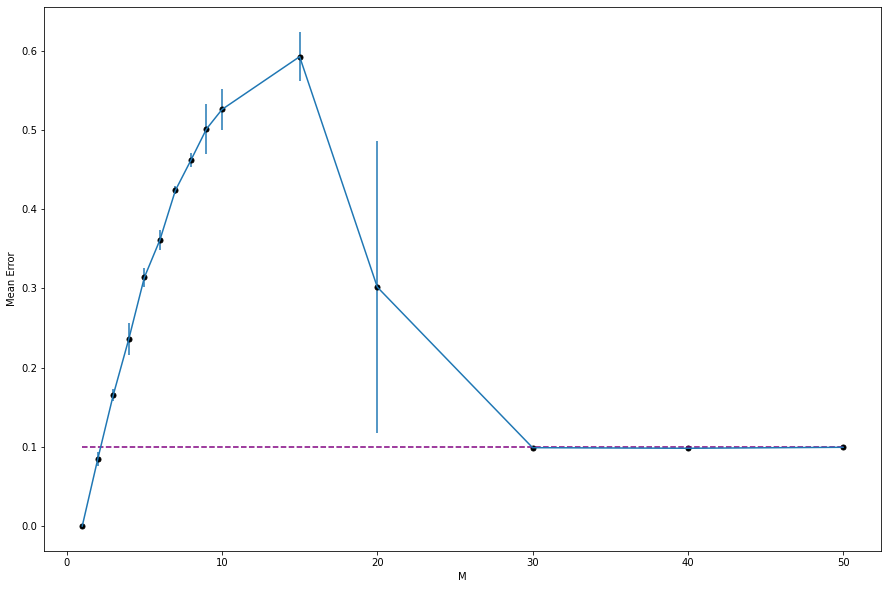

In [12]:
fig = plt.figure(figsize = (15,10))

plt.errorbar(M_values,E_values,yerr = E_error,fmt = '-')
plt.plot(M_values,E_values,'.',color = 'k',markersize = 10.)
plt.plot(M_values,0.1*np.ones(len(M_values)),'--',color = 'purple')
plt.xlabel('M')
plt.ylabel('Mean Error')
plt.show()

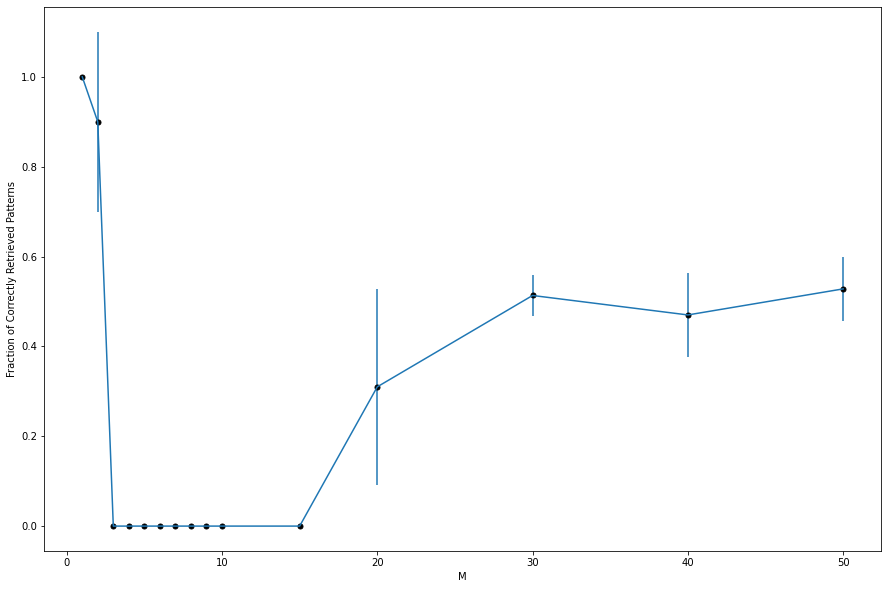

In [13]:
fig = plt.figure(figsize = (15,10))

plt.errorbar(M_values,Nr_values,yerr = Nr_error,fmt = '-')
plt.plot(M_values,Nr_values,'.',color = 'k',markersize = 10.)
plt.xlabel('M')
plt.ylabel('Fraction of Correctly Retrieved Patterns')
plt.show()

In [14]:
print("Capacity : ",capacity)

Capacity :  0.006666666666666667


In [15]:
M_values = [1,2,3,4,5,6,7,8,9,10,15,20,30,40,50]
E_values_async,E_error_async,Nr_values_async,Nr_error_async,capacity_async = Evaluate_Mean_Error(M_values,
                                                                   nr_iterations = 5,
                                                                   a = 0.1,
                                                                   nr_exc_neurons = nr_exc_neurons,
                                                                   nr_inh_neurons = nr_inh_neurons, 
                                                                   K = K,
                                                                   upd_async = True,
                                                                   max_iter = 100
                                                                   )

1
Convergence  = 0 / 1; Retrieved patterns = 1
Convergence  = 0 / 1; Retrieved patterns = 1
Convergence  = 0 / 1; Retrieved patterns = 1
Convergence  = 0 / 1; Retrieved patterns = 1
Convergence  = 0 / 1; Retrieved patterns = 1


2
Convergence  = 0 / 2; Retrieved patterns = 2
Convergence  = 0 / 2; Retrieved patterns = 0
Convergence  = 0 / 2; Retrieved patterns = 1
Convergence  = 0 / 2; Retrieved patterns = 2
Convergence  = 0 / 2; Retrieved patterns = 2


3
Convergence  = 0 / 3; Retrieved patterns = 0
Convergence  = 0 / 3; Retrieved patterns = 0
Convergence  = 0 / 3; Retrieved patterns = 0
Convergence  = 0 / 3; Retrieved patterns = 0
Convergence  = 0 / 3; Retrieved patterns = 0


4
Convergence  = 0 / 4; Retrieved patterns = 0
Convergence  = 0 / 4; Retrieved patterns = 0
Convergence  = 0 / 4; Retrieved patterns = 0
Convergence  = 0 / 4; Retrieved patterns = 0
Convergence  = 0 / 4; Retrieved patterns = 0


5
Convergence  = 0 / 5; Retrieved patterns = 0
Convergence  = 0 / 5; Retrieved patte

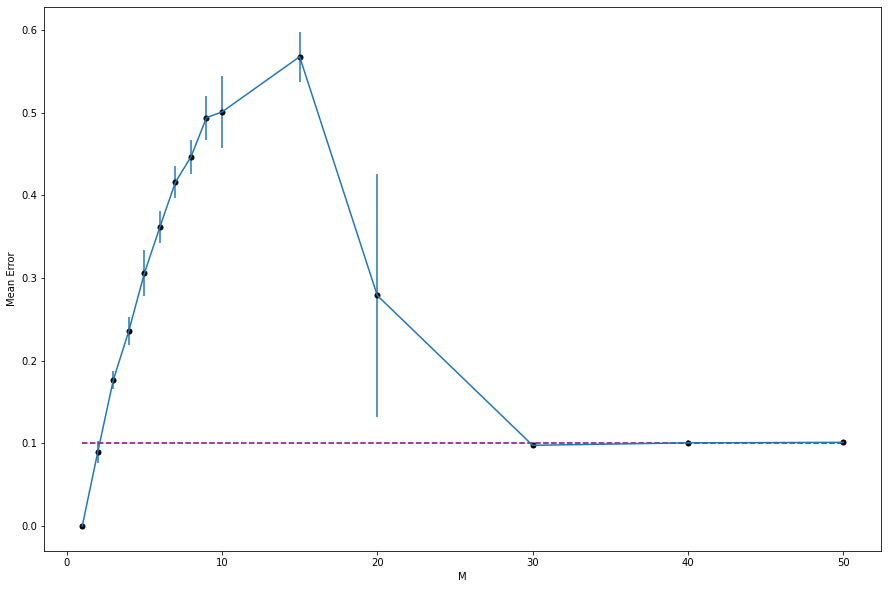

In [16]:
fig = plt.figure(figsize = (15,10))

plt.errorbar(M_values,E_values_async,yerr = E_error_async,fmt = '-')
plt.plot(M_values,E_values_async,'.',color = 'k',markersize = 10.)
plt.plot(M_values,0.1*np.ones(len(M_values)),'--',color = 'purple')
plt.xlabel('M')
plt.ylabel('Mean Error')
plt.show()

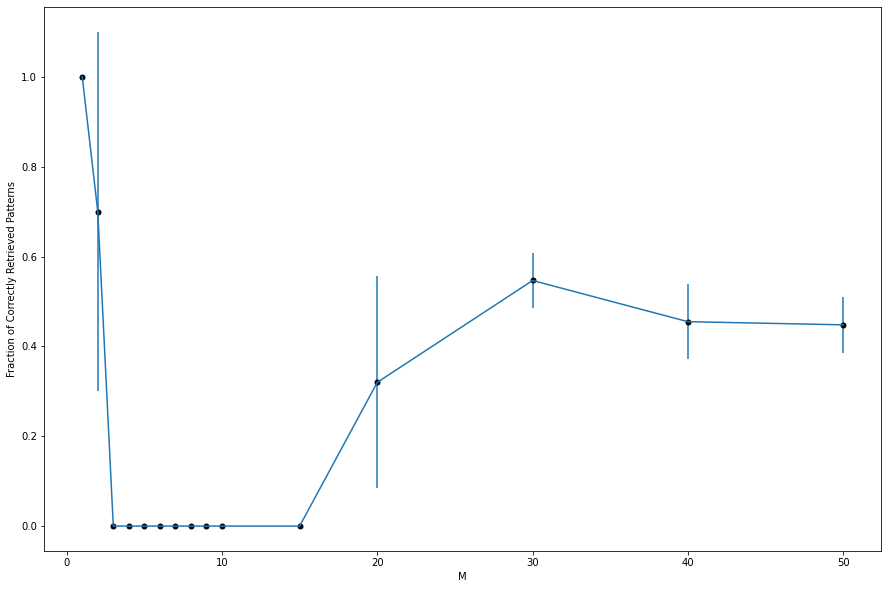

In [17]:
fig = plt.figure(figsize = (15,10))

plt.errorbar(M_values,Nr_values_async,yerr = Nr_error_async,fmt = '-')
plt.plot(M_values,Nr_values_async,'.',color = 'k',markersize = 10.)
plt.xlabel('M')
plt.ylabel('Fraction of Correctly Retrieved Patterns')
plt.show()

In [18]:
print("Capacity : ",capacity)

Capacity :  0.006666666666666667


<font size="7">
3.6

In [19]:
nr_exc_neurons = 300;
nr_inh_neurons = 80;
nr_neurons = nr_exc_neurons + 2*nr_inh_neurons;
K = 60;

# create an instance of the class HopfieldNetwork with 300 neurons
hopfield_net = network.HopfieldNetwork(nr_neurons = nr_neurons)
#create 5 patterns
factory = pattern_tools.PatternFactory(nr_exc_neurons,1)

In [20]:
import random

def weight_matrix_2_inh(pattern_list, a, nr_exc_neurons, nr_inh_neurons, K):

    N_tot = nr_exc_neurons + nr_inh_neurons;
    W = np.zeros((N_tot,N_tot))
    
    #exc - exc
    for i in range(nr_exc_neurons):
        for j in range(nr_exc_neurons):
            for μ in range(len(pattern_list)):
                W[i][j] = W[i][j] + (pattern_list[μ][i][0])*(pattern_list[μ][j][0]);
            W[i][j] = W[i][j]/nr_exc_neurons
        W[i][i] = 0;
    
    #exc - inh:  
    sum_patterns = []
    for i in range(nr_exc_neurons): 
        s = 0
        for μ in range(len(pattern_list)):
            s += pattern_list[μ][i][0];
        sum_patterns.append(s);
    
    for i in range(nr_exc_neurons): 
        for k in range(nr_exc_neurons,N_tot):
            #Only difference between the previous function lies here. 
            #Each population of inhibitory neurons has n_inh_neurons/2 neurons 
            W[i][k] = -2*a/nr_inh_neurons * sum_patterns[i]
        
    #inh - exc:
    exc_range = range(nr_exc_neurons)
    for k in range(nr_exc_neurons,N_tot):
        W[k][random.sample(exc_range, K)] = 1/K;       
    
    
    return W


def update_2_inh_async(nr_exc_neurons,nr_inh_neurons,activity):
    def upd(state_t0,weights): 
        random_neuron_idx_list = np.random.permutation(len(state_t0))
        state_t1 = state_t0.copy()
        
        for idx in random_neuron_idx_list:
            #Check whether neuron idx in exc or inh:
            
            # Neuron idx is excitatory
            if idx < nr_exc_neurons:
                h_i = np.dot(weights[idx, :], state_t1)
                s_i = np.sign(h_i)
                if s_i == 0:
                    #print("sign 0")
                    s_i = -1
                state_t1[idx] = (s_i+1)/2
            
            #Neuron idx is inhibitory
            else:
                #Inhibitory in population 1
                if idx < nr_exc_neurons + nr_inh_neurons:
                    h_k = np.dot(weights[idx, :], state_t1)
                    r = np.random.rand()
                    #print(r,h_t1[k][0])
                    if r < h_k:
                        state_t1[idx] = 1
                    else:
                        state_t1[idx] = 0
                #inhibitory in population 2
                else :
                    total_activation = sum(state_t1[0:(nr_exc_neurons)])
                    if total_activation > activity*nr_exc_neurons:
                        #print("Total Activation: %.2f/%.2f"%(total_activation,activity*nr_exc_neurons))
                        h_k = np.dot(weights[idx, :], state_t1)
                        #print(h_k)

                            
                        r = np.random.rand()
                        #print(r,h_t1[k][0])
                        if r < h_k:
                            state_t1[idx] = 1
                            #print("Activated inh neuron:",idx)
                        else:
                            state_t1[idx] = 0 
            
        return state_t1
    return upd

In [21]:
a = 0.1

pattern_list = generate_patterns(nr_patterns = 2,activity = a)
σ_pattern_list = to_σ(pattern_list)
hopfield_net.weights = weight_matrix_2_inh(σ_pattern_list,a,nr_exc_neurons,2*nr_inh_neurons,K)
np.set_printoptions(precision=3)
print(hopfield_net.weights)

[[ 0.     0.     0.    ... -0.    -0.    -0.   ]
 [ 0.     0.     0.    ... -0.    -0.    -0.   ]
 [ 0.     0.     0.    ... -0.    -0.    -0.   ]
 ...
 [ 0.     0.017  0.    ...  0.     0.     0.   ]
 [ 0.     0.017  0.    ...  0.     0.     0.   ]
 [ 0.     0.     0.017 ...  0.     0.     0.   ]]


In [22]:
upd = update_2_inh_async(nr_exc_neurons,nr_inh_neurons,a)
state = np.concatenate((np.squeeze(σ_pattern_list[0]),np.random.choice([0, 0],size = 2*nr_inh_neurons)),axis = None)
print(state)
state_1 = upd(np.squeeze(state),hopfield_net.weights)
print(state_1)

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0

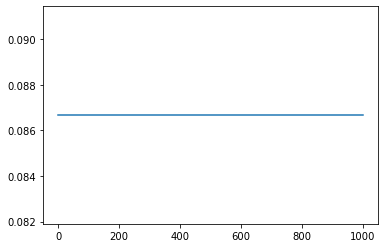

In [23]:
v = []
for i in range(1000):
    state_1 = upd(state_1,hopfield_net.weights)
    v.append(hamming_distance(state_1.reshape((nr_neurons,1))[0:nr_exc_neurons],σ_pattern_list[0]))
    
plt.plot(v)

In [24]:
print(state_1[0:nr_exc_neurons])

[0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1
 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0
 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1
 1 0 0 0]


In [25]:
print(state_1[nr_exc_neurons:])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 1 0]


In [26]:
def Mean_Error_Pattern_Retrieval(nr_patterns = 5,
                                 a = 0.5,
                                 nr_exc_neurons = 300,
                                 nr_inh_neurons = 80, 
                                 K= 60,
                                 max_iter = 1000, 
                                 verbose = False,
                                 flip_percentage = 0.05):
    
    pattern_list = generate_patterns(nr_patterns = nr_patterns,activity = a)
    σ_pattern_list = to_σ(pattern_list)
    hopfield_net.weights = weight_matrix_2_inh(σ_pattern_list,a,nr_exc_neurons,nr_inh_neurons*2,K)
    hopfield_net.set_dynamics_to_user_function(update_2_inh_async(nr_exc_neurons,nr_inh_neurons,a))
   
    E = 0;
    accepted_pattern_number = 0
    retrieved_pattern_number = 0
    for μ in range(nr_patterns):    
        noisy_init_state = pattern_tools.flip_n(pattern_list[μ], nr_of_flips=int(flip_percentage*nr_neurons))
        hopfield_net.set_state_from_pattern(to_σ([noisy_init_state]))
        
        #Initialize inhibitory Neurons
        hopfield_net.state = np.concatenate((hopfield_net.state,np.zeros(nr_inh_neurons*2)),axis = None)
        np.reshape(hopfield_net.state,(nr_exc_neurons+nr_inh_neurons*2,1))
        #print("INITIAL ACTIVATION: %.2f"%(sum(hopfield_net.state[0:(nr_exc_neurons+nr_inh_neurons)])))

        #print(hopfield_net.state.shape)
        #Run until convergence
        count = 0;
        conv = False
        while not conv:
            count = count + 1;
            #print(count)
            state_old = hopfield_net.state.copy();
            hopfield_net.run(nr_steps=1);
            state = hopfield_net.state.copy();
            aux = max(abs(state - state_old))
            conv = (aux<1)
            #print(state == state_old)
            #print(conv)
            if count == max_iter:
                if verbose:
                    print("Network state did not converge for pattern ",μ)
                break
        if conv:
            if verbose:
                print('Pattern %i - Converged after %i iterations'%(μ,count)) 
            accepted_pattern_number = accepted_pattern_number + 1;
        
        state = factory.reshape_patterns([hopfield_net.state[0:nr_exc_neurons]])
        h = hamming_distance(state[0],σ_pattern_list[μ])
        if h<0.1:
            retrieved_pattern_number += 1;
        if verbose:
            print("Hamming distance = ",h)
        E = E + h
        
    
    print("Convergence  = %d / %d; Retrieved patterns = %d"%(accepted_pattern_number,nr_patterns,retrieved_pattern_number))

    return E/nr_patterns , retrieved_pattern_number/nr_patterns;

In [27]:
Mean_Error_Pattern_Retrieval(nr_patterns = 30,
                             a= 0.1,
                             nr_exc_neurons = nr_exc_neurons,
                             nr_inh_neurons = nr_inh_neurons, 
                             K= K,
                             verbose = True)

Pattern 0 - Converged after 4 iterations
Hamming distance =  0.08333333333333333
Pattern 1 - Converged after 4 iterations
Hamming distance =  0.1
Pattern 2 - Converged after 4 iterations
Hamming distance =  0.11666666666666667
Pattern 3 - Converged after 4 iterations
Hamming distance =  0.1
Pattern 4 - Converged after 4 iterations
Hamming distance =  0.08666666666666667
Pattern 5 - Converged after 4 iterations
Hamming distance =  0.09666666666666666
Pattern 6 - Converged after 4 iterations
Hamming distance =  0.10666666666666667
Pattern 7 - Converged after 4 iterations
Hamming distance =  0.12333333333333334
Pattern 8 - Converged after 4 iterations
Hamming distance =  0.08333333333333333
Pattern 9 - Converged after 4 iterations
Hamming distance =  0.08333333333333333
Pattern 10 - Converged after 4 iterations
Hamming distance =  0.08666666666666667
Pattern 11 - Converged after 4 iterations
Hamming distance =  0.07
Pattern 12 - Converged after 4 iterations
Hamming distance =  0.083333333

(0.09366666666666669, 0.6333333333333333)

In [28]:
from scipy.interpolate import interp1d
def Evaluate_Mean_Error(M_values,
                        nr_iterations = 5, 
                        a= 0.5, 
                        nr_exc_neurons = 300,
                        nr_inh_neurons = 80,
                        K= 60,
                        max_iter = 1000,
                        verbose = False,
                        flip_percentage = 0.05):

    
    E_values =[];
    E_error  =[];
    Nr_values =[];
    Nr_error  =[];

    for M in M_values:
        print(M)
        E_M = [];
        Nr_M = [];
        for run in range(nr_iterations):
            e,n = Mean_Error_Pattern_Retrieval(nr_patterns = M,
                                               a = a,
                                               nr_exc_neurons = nr_exc_neurons,
                                               nr_inh_neurons = nr_inh_neurons,
                                               K = K,
                                               max_iter = max_iter,
                                               verbose = verbose,
                                               flip_percentage = flip_percentage)
            
            E_M.append(e);
            Nr_M.append(n);

        E = np.mean(E_M) 
        var_E = np.std(E_M)
        Nr = np.mean(Nr_M) 
        var_Nr = np.std(Nr_M)

        E_values.append(E)
        E_error.append(var_E)
        Nr_values.append(Nr)
        Nr_error.append(var_Nr)
        
        if verbose:
            print('nr of Patterns:',M)
            print("Mean Error: %f +- %f"%(E,var_E))
            print("Fraction: %f +- %f"%(Nr,var_Nr))

        print('\n')
         
    capacity = M_max(M_values,E_values)/(nr_exc_neurons)
    return E_values,E_error,Nr_values,Nr_error,capacity

def M_max(M_values,E_values,threshold = 0.1):
    C = 0;
    E_interp = interp1d(M_values, E_values, kind='cubic')
    m = np.arange(M_values[0],M_values[-1])
    k = 0
    while (E_interp(m[k])-threshold)*(E_interp(m[k+1])-threshold) > 0 and k<(len(m)-2):
        k = k+1
    
    if k<(len(m)-2):
        m_max = m[k]   
    else:
        print('Capacity not Found')
        m_max = m[-1]
    return m_max

In [29]:
M_values = [1,2,3,4,5,6,7,8,9,10,15,20,30,40,50]
E_values_2_inh,E_error_2_inh,Nr_values_2_inh,Nr_error_2_inh,capacity_2_inh = Evaluate_Mean_Error(M_values,
                                                                   nr_iterations = 5,
                                                                   a = 0.1,
                                                                   nr_exc_neurons = nr_exc_neurons,
                                                                   nr_inh_neurons = nr_inh_neurons, 
                                                                   K = K,
                                                                   max_iter = 100
                                                                   )

1
Convergence  = 0 / 1; Retrieved patterns = 1
Convergence  = 0 / 1; Retrieved patterns = 1
Convergence  = 0 / 1; Retrieved patterns = 1
Convergence  = 0 / 1; Retrieved patterns = 1
Convergence  = 0 / 1; Retrieved patterns = 1


2
Convergence  = 0 / 2; Retrieved patterns = 1
Convergence  = 0 / 2; Retrieved patterns = 2
Convergence  = 0 / 2; Retrieved patterns = 1
Convergence  = 0 / 2; Retrieved patterns = 1
Convergence  = 0 / 2; Retrieved patterns = 1


3
Convergence  = 0 / 3; Retrieved patterns = 2
Convergence  = 0 / 3; Retrieved patterns = 0
Convergence  = 0 / 3; Retrieved patterns = 1
Convergence  = 0 / 3; Retrieved patterns = 0
Convergence  = 0 / 3; Retrieved patterns = 2


4
Convergence  = 0 / 4; Retrieved patterns = 0
Convergence  = 0 / 4; Retrieved patterns = 0
Convergence  = 0 / 4; Retrieved patterns = 0
Convergence  = 0 / 4; Retrieved patterns = 0
Convergence  = 0 / 4; Retrieved patterns = 0


5
Convergence  = 0 / 5; Retrieved patterns = 0
Convergence  = 0 / 5; Retrieved patte

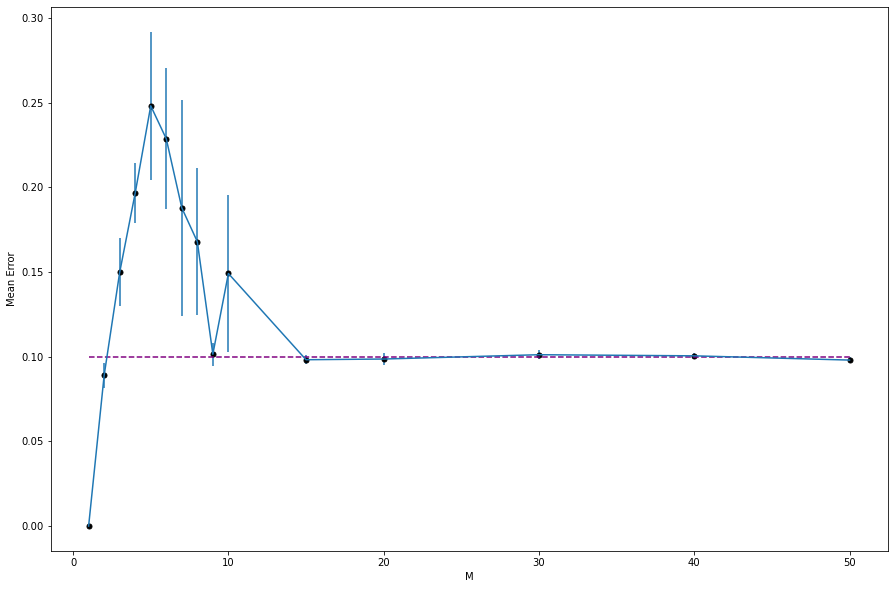

In [30]:
fig = plt.figure(figsize = (15,10))

plt.errorbar(M_values,E_values_2_inh,yerr = E_error_2_inh,fmt = '-')
plt.plot(M_values,E_values_2_inh,'.',color = 'k',markersize = 10.)
plt.plot(M_values,0.1*np.ones(len(M_values)),'--',color = 'purple')
plt.xlabel('M')
plt.ylabel('Mean Error')
plt.show()

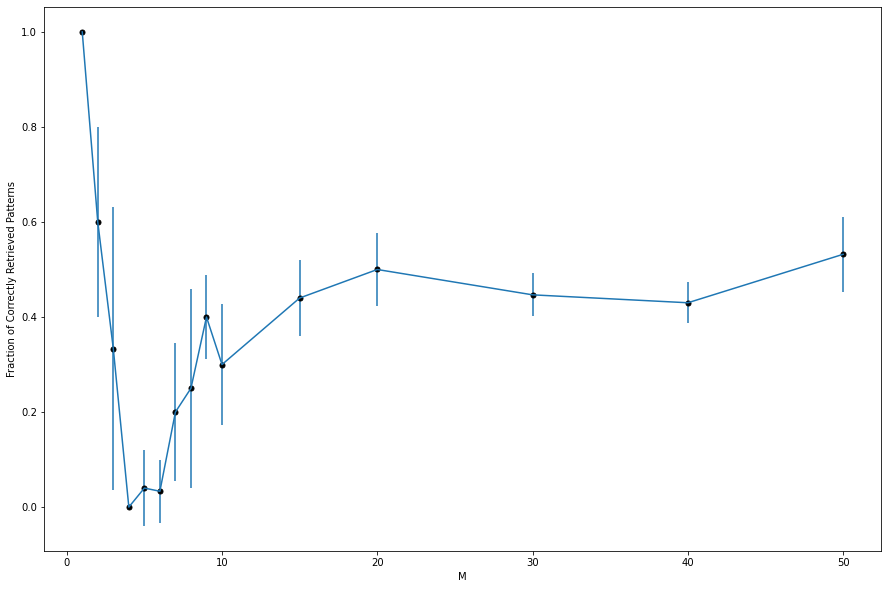

In [31]:
fig = plt.figure(figsize = (15,10))

plt.errorbar(M_values,Nr_values_2_inh,yerr = Nr_error_2_inh,fmt = '-')
plt.plot(M_values,Nr_values_2_inh,'.',color = 'k',markersize = 10.)
plt.xlabel('M')
plt.ylabel('Fraction of Correctly Retrieved Patterns')
plt.show()

In [32]:
print("Capacity : ",capacity)

Capacity :  0.006666666666666667


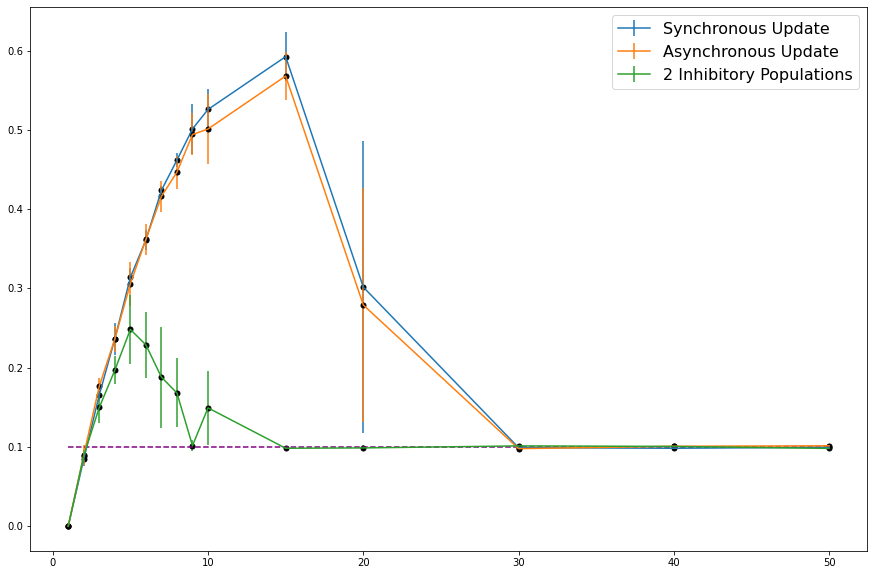

In [40]:
fig = plt.figure(figsize = (15,10))

plt.errorbar(M_values,E_values,yerr = E_error,fmt = '-',label = "Synchronous Update")
plt.plot(M_values,E_values,'.',color = 'k',markersize = 10.)

plt.errorbar(M_values,E_values_async,yerr = E_error_async,fmt = '-',label = "Asynchronous Update")
plt.plot(M_values,E_values_async,'.',color = 'k',markersize = 10.)

plt.errorbar(M_values,E_values_2_inh,yerr = E_error_2_inh,fmt = '-',label = "2 Inhibitory Populations")
plt.plot(M_values,E_values_2_inh,'.',color = 'k',markersize = 10.)


plt.plot(M_values,0.1*np.ones(len(M_values)),'--',color = 'purple')

plt.xlabel('M')
plt.ylabel('Mean Error')

plt.legend(fontsize= 16)
plt.show()

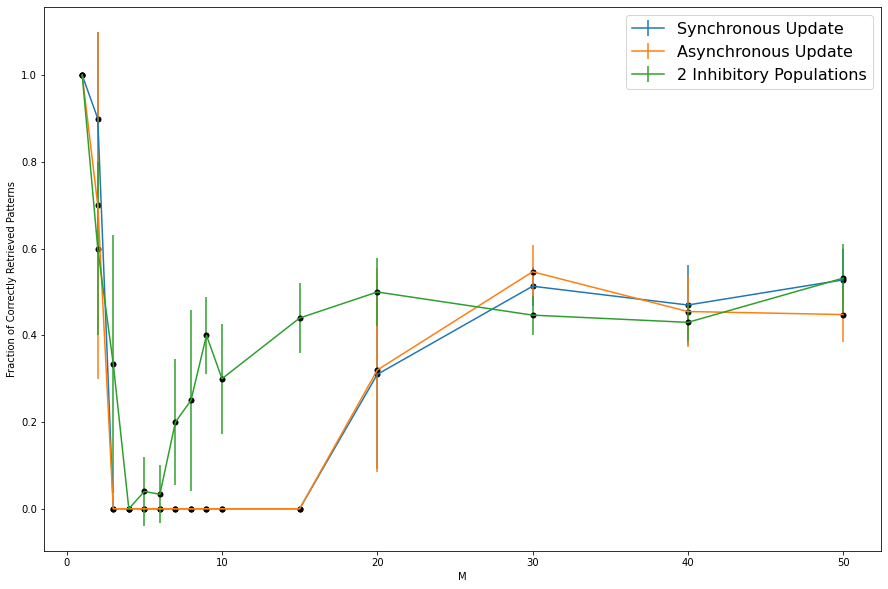

In [41]:
fig = plt.figure(figsize = (15,10))

plt.errorbar(M_values,Nr_values,yerr = Nr_error,fmt = '-',label = "Synchronous Update")
plt.plot(M_values,Nr_values,'.',color = 'k',markersize = 10.)

plt.errorbar(M_values,Nr_values_async,yerr = Nr_error_async,fmt = '-',label = "Asynchronous Update")
plt.plot(M_values,Nr_values_async,'.',color = 'k',markersize = 10.)

plt.errorbar(M_values,Nr_values_2_inh,yerr = Nr_error_2_inh,fmt = '-',label = "2 Inhibitory Populations")
plt.plot(M_values,Nr_values_2_inh,'.',color = 'k',markersize = 10.)


plt.xlabel('M')
plt.ylabel('Fraction of Correctly Retrieved Patterns')

plt.legend(fontsize = 16)
plt.show()